# t-Distributed Stochastic Neighbor Embedding (t-SNE)

### 🎯 Goal
t-SNE is a non-linear dimensionality-reduction algorithm primarily used for visualization (typically to 2D or 3D). It seeks to represent high-dimensional data in a low-dimensional space so that **local neighborhood relationships** are preserved.

---

### 🧬 The Mechanism

#### 1. Affinity Construction (High-Dim)
For each point $x_i$ in high dimensions, t-SNE forms a conditional probability $p_{j|i}$ that $x_j$ is a neighbor of $x_i$.
* These are **Gaussian-based**.
* The bandwidth is chosen so the **perplexity** of the distribution equals a user-specified value.
* Symmetrize to get the joint probability: $p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}$.

#### 2. Affinity in Low-Dim
In the low-dim map (points $y_i$), we define a heavy-tailed **Student t-distribution** kernel (with 1 degree of freedom) to produce $q_{ij}$:

$$q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l} (1 + ||y_k - y_l||^2)^{-1}}$$

> **Note:** The heavy-tailed kernel avoids the **"crowding problem"** and allows distant clusters to remain separated.

#### 3. Objective
Minimize the **Kullback-Leibler (KL) divergence** via gradient descent on the positions $y_i$:

$$KL(P||Q) = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}$$

---

### 🛠️ Important Algorithmic Pieces
* **Early Exaggeration:** In the first phase, $p_{ij}$ is multiplied by a factor (default 12). This forces clusters to form tight groups early on so they have more room to move around each other.
* **Optimization:** Uses gradient descent with momentum. `scikit-learn` utilizes the **Barnes-Hut approximation** for speed $O(N \log N)$ for larger datasets.
* **Non-deterministic:** Results vary between runs due to random initialization unless a `random_state` is fixed.

---

### ⚖️ What it Preserves vs. What it Doesn't
| Preserves ✅ | Doesn't Guarantee ❌ |
| :--- | :--- |
| **Local Structure:** Who our closest neighbors are. | **Global Distances:** Distances between far-apart clusters are often meaningless. |
| **Cluster Identification:** Finding natural groupings. | **Linearity:** It is a non-linear transformation; we cannot "inverse transform" back to the original space easily. |

> **Warning:** t-SNE is not designed as a general feature extractor for downstream supervised learning; it is primarily a visualization tool.

## ⚙️ Key Parameters: Tuning & Practical Ranges

These parameters control how t-SNE interprets our data and how the optimization process behaves.

| Parameter | What it Controls | Practical Range / Default |
| :--- | :--- | :--- |
| `n_components` | The dimension of the embedded space. | **2 or 3** (for visualization). |
| `perplexity` | The effective number of neighbors to consider. | **5 – 50** (Default: 30). |
| `learning_rate` | The step size for optimization. | **10 – 1000**. |
| `n_iter` | Number of optimization iterations. | **250 – 1000+**. |
| `init` | Initialization of the low-dim points. | `'pca'` (stable) or `'random'`. |
| `early_exaggeration`| How tightly grouped the clusters are initially. | Default **12.0**. |
| `metric` | The distance metric in input space. | `'euclidean'` (default) or custom. |
| `method` | The algorithm used for calculation. | `'barnes_hut'` (fast) or `'exact'`. |
| `random_state` | Seed for the random number generator. | Any integer (for reproducibility). |

---

### 💡 Practical Tuning Tips

* **Perplexity is sensitive:** * *Smaller perplexity* → Focuses on very local structure (can create tiny, fragmented clusters).
    * *Larger perplexity* → Captures more global structure but can blur distinct clusters together if too high.
* **Learning Rate Rule of Thumb:** If the optimization stalls, try setting our `learning_rate` to approximately $\text{max}(10, \frac{n_{samples}}{12})$.
* **Convergence:** If our plot looks like a "ball" or a disorganized cloud, we may need more iterations (`n_iter`).
* **Stability:** Using `init='pca'` is generally recommended over `'random'` as it is more globally stable and less sensitive to the random seed.

## 🚀 Practical Demonstration: Implementing t-SNE

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Trustworthiness (n_neighbors=5): 0.9884976525821596


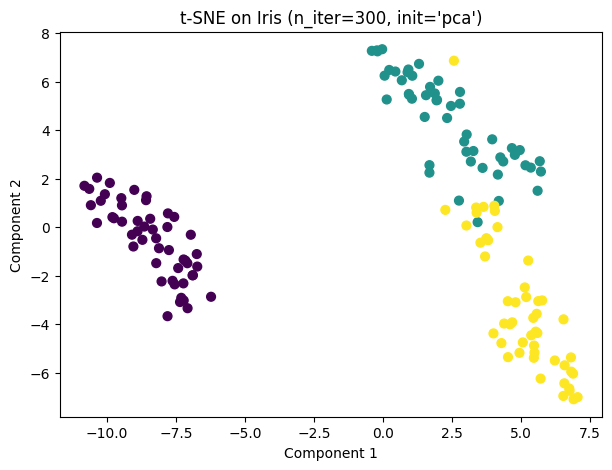

In [1]:
# ---------- 1) Quick t-SNE visualization (Iris) ----------
from sklearn.datasets import load_iris
from sklearn.manifold import TSNE, trustworthiness
import matplotlib.pyplot as plt

iris = load_iris()
X = iris.data
y = iris.target

tsne = TSNE(n_components=2, random_state=42, n_iter=300, init='pca')
X2 = tsne.fit_transform(X)

print("Trustworthiness (n_neighbors=5):", trustworthiness(X, X2, n_neighbors=5))

plt.figure(figsize=(7,5))
plt.scatter(X2[:,0], X2[:,1], c=y, s=40)
plt.title("t-SNE on Iris (n_iter=300, init='pca')")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [2]:
# ---------- 2) Light randomized hyperparameter search using trustworthiness ----------
# Notes: we evaluate embeddings on the same dataset using trustworthiness; that is valid
# for finding stable t-SNE params that preserve local neighborhoods.
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.manifold import TSNE, trustworthiness
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterSampler

wine = load_wine()
Xw = wine.data
yw = wine.target

param_grid = {
    'perplexity': [5, 10, 30, 50],
    'learning_rate': [10, 50, 100, 200],
    'n_iter': [250, 500],
    'init': ['pca', 'random'],
    'early_exaggeration': [4.0, 12.0],
    'method': ['barnes_hut']  # exact is slow for > small N
}

n_samples = 12  # sample 12 param combos for speed; increase as needed
param_list = list(ParameterSampler(param_grid, n_iter=n_samples, random_state=0))

results = []
for params in param_list:
    ts = TSNE(n_components=2,
              perplexity=params['perplexity'],
              learning_rate=params['learning_rate'],
              n_iter=params['n_iter'],
              init=params['init'],
              early_exaggeration=params['early_exaggeration'],
              method=params['method'],
              random_state=0)
    Y = ts.fit_transform(Xw)
    tw = trustworthiness(Xw, Y, n_neighbors=5)
    sil = silhouette_score(Y, yw)  # optional supervised metric for cluster separation
    results.append({**params, 'trustworthiness': tw, 'silhouette': sil})

df = pd.DataFrame(results).sort_values('trustworthiness', ascending=False)
print(df.head(8))
# pick best and visualize
best = df.iloc[0]
print("Best params:", best.to_dict())


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarnin

    perplexity  n_iter      method  learning_rate    init  early_exaggeration  \
2           30     500  barnes_hut            100     pca                12.0   
5            5     500  barnes_hut             50  random                12.0   
9           50     500  barnes_hut             10     pca                 4.0   
10           5     500  barnes_hut            200  random                 4.0   
6           50     500  barnes_hut            200  random                12.0   
0            5     250  barnes_hut             50  random                 4.0   
4            5     250  barnes_hut             50     pca                 4.0   
7            5     250  barnes_hut             10  random                12.0   

    trustworthiness  silhouette  
2          0.997204    0.258663  
5          0.996563    0.090704  
9          0.996490    0.262980  
10         0.996385    0.062600  
6          0.995691    0.263139  
0          0.995638    0.133330  
4          0.994964    0.199454 

## ⚠️ Important Constraint: t-SNE in Scikit-Learn Pipelines

One of the biggest practical hurdles with t-SNE is that it **does not implement a `.transform()` method**.

### The Problem
While most `sklearn` transformers allow us to `fit` on training data and `transform` new test data, t-SNE only provides `fit_transform()`.
* **Why?** Because t-SNE is a non-parametric manifold learning technique. It learns an embedding for a specific set of points; it doesn't "learn a function" that can be applied to new, unseen points later.
* **Pipeline Impact:** We cannot plug `TSNE` into a `Pipeline` if we plan to use `GridSearchCV` or `cross_val_score`, because those tools require a `.transform()` call to process the validation folds.

---

### 🛠️ Recommended Workarounds

#### 1. Use UMAP or PCA instead

* **UMAP** (*Uniform Manifold Approximation and Projection*) is the modern alternative. It preserves global structure better, is faster, and **does** support `.transform()`.
* **PCA** is linear and much simpler, always supporting `.transform()`.

#### 2. Offline Hyperparameter Evaluation
Instead of using `GridSearchCV`, evaluate t-SNE hyperparameters by running them on the full dataset and calculating internal metrics:
* **Trustworthiness:** Measures how well the local neighborhood is preserved.
* **Silhouette Score:** Measures how well-defined the resulting clusters are.

#### 3. Parametric t-SNE (Advanced)
If we absolutely must use t-SNE for new data, we can train a Neural Network (a "surrogate model") to learn the mapping that t-SNE created. The neural network then acts as our `.transform()` function.

---

### ⚖️ Quick Comparison for Pipelines

| Feature | PCA | t-SNE | UMAP |
| :--- | :--- | :--- | :--- |
| **Supports `.transform()`** | ✅ Yes | ❌ No | ✅ Yes |
| **Speed** | ⚡ Fast | 🐢 Slow | 🚀 Fast |
| **Preserves Global Structure** | ✅ High | ❌ Low | 🔶 Medium/High |
| **Best Use Case** | Baseline / Denoising | Deep Visualization | Large Scale / Pipelines |

## ⚖️ How to Tune t-SNE Properly (Recommended Workflow)

Since t-SNE doesn't fit into standard cross-validation, follow this quantitative workflow to find the best representation of our data.

---

### 1. Use Quantitative Metrics
Don't rely on "eye-balling" alone. Use **Trustworthiness** (`sklearn.manifold.trustworthiness`).
* **What it measures:** How well the $k$-nearest neighbor relationships are preserved from the high-dimensional space to the 2D/3D embedding.
* **Goal:** A score closer to **1.0** indicates better preservation of local structure.

### 2. The Stochastic Strategy
Because t-SNE is non-deterministic:
* **Multiple Seeds:** Evaluate each parameter set using 3–5 different `random_state` values.
* **Average the Metric:** Use the mean trustworthiness score across these seeds to decide if a parameter change actually helped.

---

### 3. Search Space Suggestions
If we are running a **Randomized Search**, consider these ranges:

| Parameter | Search Values | Notes |
| :--- | :--- | :--- |
| **`perplexity`** | `[5, 10, 20, 30, 40, 50]` | Start at 30; increase for more global context. |
| **`learning_rate`**| `[10, 50, 100, 200, 500]` | Scale up to 1000 for very large datasets ($N > 10,000$). |
| **`n_iter`** | `[250, 500, 1000, 2000]` | Higher is usually more stable but slower. |
| **`init`** | `['pca']` | Highly recommended for stability and reproducibility. |
| **`early_exag`** | `[4, 8, 12, 16]` | Smaller values allow for more relaxed clusters. |

---

### 4. The Final "Sanity Check"
**Visual inspection remains essential.** Even if a configuration has a high trustworthiness score, we must plot it to check for:
* **"String" Artifacts:** Points forming strange lines (often a sign of too low perplexity).
* **"The Ball":** A single undifferentiated mass (often a sign of low iterations or bad learning rate).



> **Advanced Tip:** If our CPU budget allows, run a **Random Search** over 20–50 parameter combinations. This is often more efficient than an exhaustive grid search for discovering the "sweet spot" of our specific dataset.

## ⚠️ Caution: When t-SNE Fails or Misleads Us

t-SNE is a powerful visualization tool, but it is prone to misinterpretation. Be aware of these common pitfalls before drawing conclusions from our plots.

---

### 🚫 Common Pitfalls
* **Meaningless Cluster Distances:** The distance between two clusters in a t-SNE plot does **not** necessarily represent their actual similarity. Do not infer hierarchy or "relatedness" based on the raw map layout.
* **Large Datasets ($N > 50k$):** t-SNE can become prohibitively slow. While Barnes-Hut helps, it may still struggle compared to UMAP.
* **The "Garbage In, Garbage Out" Rule:** t-SNE emphasizes local neighborhood structure. If our input features are noisy or uninformative, the "neighbors" are random, and the embedding will be meaningless.
* **Feature Engineering Misuse:** Since t-SNE is non-parametric and lacks a `.transform()` method, using its output as a feature for a classifier (like Random Forest) is usually a mistake.
* **Perplexity Pitfalls:** Keep our `perplexity < N/3`. Using a perplexity larger than our sample size or a tiny value (e.g., 2) will create visual artifacts that don't exist in the data.



---

### 🔄 Alternatives to Consider

If t-SNE isn't providing the clarity we need for our project, we consider these alternatives:

| Method | Best Use Case | Key Advantage |
| :--- | :--- | :--- |
| **UMAP** | Production Pipelines | Faster, preserves global structure, supports `.transform()`. |
| **PCA** | Denoising / Baseline | Linear, deterministic, and extremely fast. |
| **TriMap / LargeVis** | Global Structure | Better at preserving the "big picture" of the data density. |

---